In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 生成数据

In [2]:
def generation(n=100,p=2,K=3):
    """
    n是数据量;
    p是数据维度;
    K是类数，K个簇
    """
    mu = 5*np.random.rand(p)
    sigma = np.random.rand(1)*np.eye(p)
    data = np.random.multivariate_normal(mu,sigma,n//K)
    for i in range(K-1):
        mu = 10*np.random.randn(p)
        sigma = np.random.rand(1)*np.eye(p)
        if i==K-1:
            data = np.append(data,np.random.multivariate_normal(mu,sigma,n-n//K*K),axis=0)
        else:
            data = np.append(data,np.random.multivariate_normal(mu,sigma,n//K),axis=0)
    return data

## 数据一维观察

In [3]:
n=60
p=2
K=3
data = generation(n,p,K)
x,y = data.T

Text(0.5, 0, 'x')

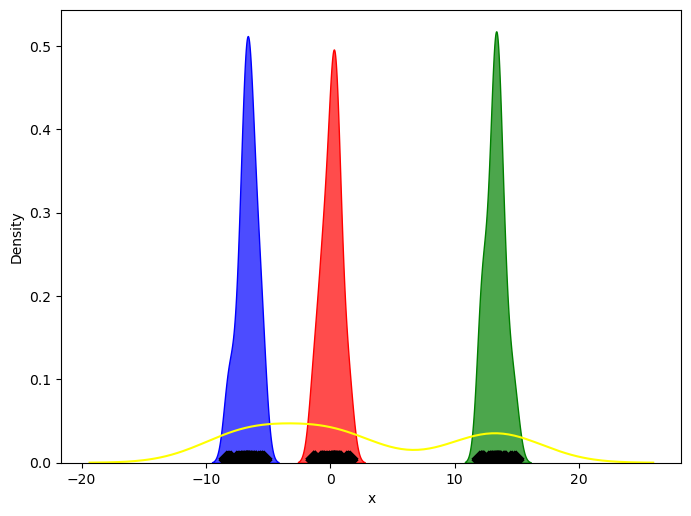

In [4]:
plt.figure(figsize=(8,6), dpi= 100)
sns.kdeplot(x[0:20], shade=True, color="r", alpha=.7)
sns.kdeplot(x[20:40], shade=True, color="g", alpha=.7)
sns.kdeplot(x[40:60], shade=True, color="b", alpha=.7)
sns.kdeplot(x, color="yellow")
plt.scatter(x,0.005*np.ones(60),marker='x',c='black',linewidths=10)
plt.xlabel("x")

Text(0.5, 0, 'y')

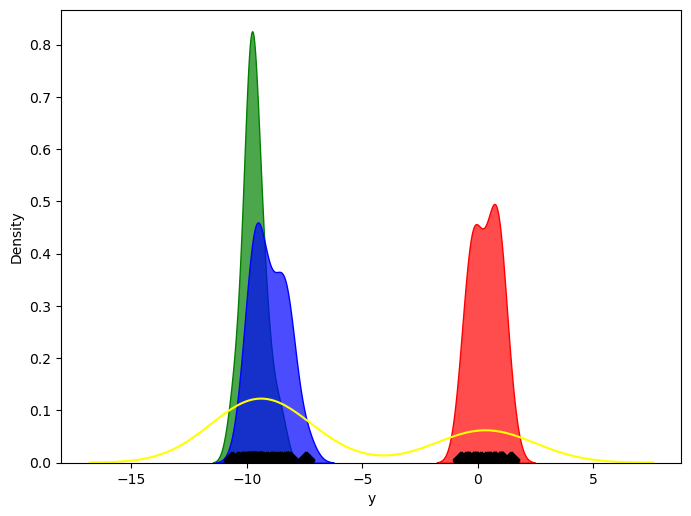

In [5]:
plt.figure(figsize=(8,6), dpi= 100)
sns.kdeplot(y[0:20], shade=True, color="r", alpha=.7)
sns.kdeplot(y[20:40], shade=True, color="g", alpha=.7)
sns.kdeplot(y[40:60], shade=True, color="b", alpha=.7)
sns.kdeplot(y, color="yellow")
plt.scatter(y,0.005*np.ones(60),marker='x',c='black',linewidths=10)
plt.xlabel("y")

## 数据二维观察

Text(0, 0.5, 'y')

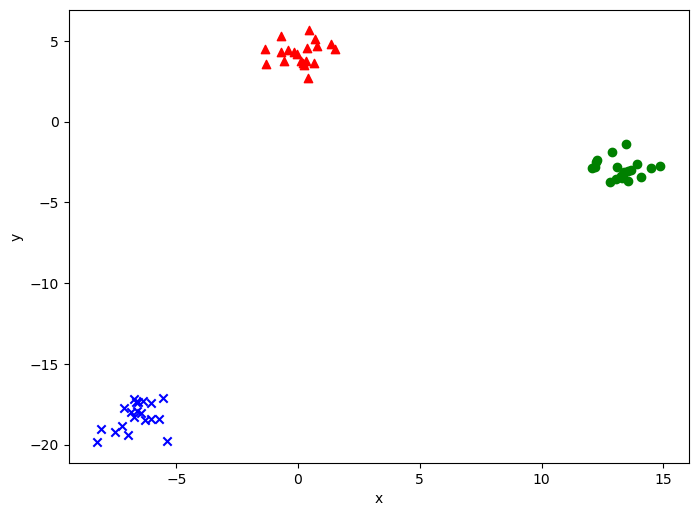

In [5]:
plt.figure(figsize=(8,6), dpi= 100)
plt.scatter(x[0:20],y[0:20],marker='^',c='r')
plt.scatter(x[20:40],y[20:40],marker='o',c='g')
plt.scatter(x[40:60],y[40:60],marker='x',c='b')
plt.axis()
plt.xlabel("x")
plt.ylabel("y")

# EM算法(简化版)

In [14]:
n=200
p=2
K=3
data = generation(n,p,K).T

In [15]:
p,n = data.shape     # n个数据，p是维度
k=5
posterior = np.random.rand(n,k)
sigma = np.repeat(np.expand_dims(np.zeros((p,p)), axis=0), k, axis=0)

for i in range(1000):
    posterior = posterior/np.tile(np.sum(posterior,axis=1).reshape(n,1),(1,k))
    s = np.sum(posterior,axis=0)
    w = s/n
    mu = np.dot(data,posterior)/s
    for j in range(k):
        t = data-np.tile(mu[:,j].reshape(p,1),[1,n])
        sigma[j] = np.dot(np.multiply(t,np.tile(posterior[:,j],[p,1])),t.T)/s[j]
        posterior[:,j] = w[j] * np.exp(-np.sum(np.multiply(t, np.dot(np.linalg.pinv(sigma[j]),t)),axis=0)/2) \
                        /np.sqrt(np.linalg.det((sigma[j])))
    if i>0:
        w_error = np.linalg.norm((w - w_), ord=2)
        mu_error = np.linalg.norm((mu - mu_), ord=2)
        sigma_error = np.linalg.norm((sigma - sigma_))
        if (w_error + mu_error+sigma_error) < 1e-6:
            break
        
    w_ = w
    mu_ = mu
    sigma_ = sigma

Text(0, 0.5, 'y')

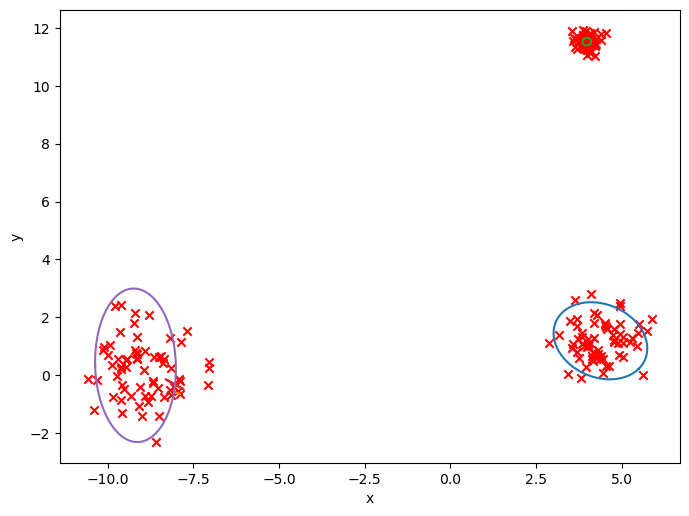

In [16]:
k = w.shape[0]
v = np.linspace(0,2*np.pi,100)
x,y = data
plt.figure(figsize=(8,6), dpi= 100)
plt.scatter(x,y,marker='x',c='r')
for i in range(k):
    D,V = np.linalg.eig(sigma[i])
    X = 10*w[i]*np.dot(V.T,np.array([np.cos(v)*D[0],np.sin(v)*D[1]]))
    plt.plot(mu[0,i]+X[0,:],mu[1,i]+X[1,:])
    
plt.axis()
plt.xlabel("x")
plt.ylabel("y")

# EM算法（封装版）

In [17]:
n=200
p=2
K=3
data = generation(n,p,K)
x,y = data.T

In [18]:
def e_step(data, w, mu, sigma):
    """
    E步：计算后验概率（隐藏变量）
    """
    n, p = data.shape
    k = w.shape[0]
    posterior = np.zeros((n, k))
    
    for i in range(k):
        t = data-mu[i]
        posterior[:,i] = w[i] * np.exp(-np.sum(np.multiply(np.dot(t,np.linalg.pinv(sigma[i])),t),axis=1)/2) \
                        /np.sqrt(np.linalg.det((sigma[i])))
    posterior = posterior/np.tile(np.sum(posterior,axis=1).reshape(n,1),(1,k))
     
    return posterior


def m_step(data,posterior):
    """
    M步：更新系数、均值、协方差矩阵
    """
    n, p = data.shape
    k = posterior.shape[1]
    
    s = np.sum(posterior,axis=0)
    w_ = s/n
    mu_ = np.dot(posterior.T,data)/np.tile(s.reshape(k,1),[1,p])
    sigma_ = np.repeat(np.expand_dims(np.eye(p), axis=0), k, axis=0)
    
    for i in range(k):
        t = data-mu_[i]
        sigma_[i] = np.dot(t.T,np.multiply(t,np.tile(posterior[:,i].reshape(n,1),[1,p])))/s[i]
        
    return w_, mu_, sigma_
    
    
def GMM(data,k=5):
    """
    data:数据
    k:隐变量的个数
    
    """
    
    # 初始化为k个高斯核函数
    
    n, p = data.shape     # n个数据，p是维度
    posterior = np.random.rand(n,k)
    posterior = posterior/np.tile(np.sum(posterior,axis=1).reshape(n,1),(1,k))    # 保证初始化的w和为1
    w,mu,sigma = m_step(data,posterior)                                           # 初始化参数
    
    # EM迭代
    for i in range(10000):
        posterior = e_step(data, w, mu, sigma)
        w_, mu_, sigma_ = m_step(data, posterior)
        
        w_error = np.linalg.norm((w - w_), ord=2)
        mu_error = np.linalg.norm((mu - mu_), ord=2)
        sigma_error = np.linalg.norm((sigma - sigma_))
        
        if (w_error + mu_error+sigma_error) < 1e-6:
            break
        else:
            w = w_
            mu = mu_
            sigma = sigma_
            
    return w, mu, sigma, i

In [19]:
w, mu, sigma, i= GMM(data,5)

Text(0, 0.5, 'y')

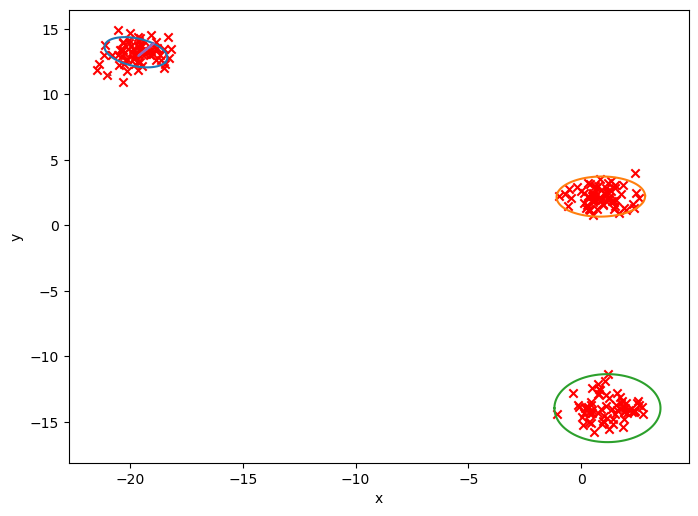

In [20]:
k = w.shape[0]
v = np.linspace(0,2*np.pi,100)
x,y = data.T
plt.figure(figsize=(8,6), dpi= 100)
plt.scatter(x,y,marker='x',c='r')
for i in range(k):
    D,V = np.linalg.eig(sigma[i])
    X = 10*w[i]*np.dot(V.T,np.array([np.cos(v)*D[0],np.sin(v)*D[1]]))
    plt.plot(mu.T[0,i]+X[0,:],mu.T[1,i]+X[1,:])
    
plt.axis()
plt.xlabel("x")
plt.ylabel("y")

**GMM算法遗憾的地方的是np.linalg.det((sigma)) 可能因为sigma奇异导致程序无法继续运行**

解决方案：
1. $\sum  + \lambda I$
2. 利用$|\sum||\sum^{-1}|=1$，将除法变成乘法，可一定程度解决小数除法问题

暂时未真正解决此问题，有办法私聊2818657803@qq.com